In [1]:
# Importer les bibliothèques essentielles
import os
import pandas as pd
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import lr_scheduler

from tqdm import tqdm
# Monter Google Drive pour accéder au dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Définir le chemin du dataset
dataset_path = '/content/drive/MyDrive/dataset_original'
image_size = (224, 224)  # Taille standard pour les modèles préentraînés

In [3]:
# Définir le mapping des étiquettes
label_map = {
    "Photo": 1,
    "Text": 0,
    "Sketch": 0,
    "Schematics": 0,
    "Painting": 0
}

# Filtrer et charger les données valides
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

def is_image_file(filename):
    return filename.lower().endswith(valid_extensions)

data = []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path) and folder in label_map:
        label = label_map[folder]
        for img_file in os.listdir(folder_path):
            if is_image_file(img_file):
                img_path = os.path.join(folder_path, img_file)
                data.append({"image_path": img_path, "label": label})
            else:
                print(f"Skipping non-image file: {img_file}")

# Créer un DataFrame
df = pd.DataFrame(data)
print(f"Total images: {len(df)}")
print(df['label'].value_counts())

Skipping non-image file: desktop.ini
Total images: 32179
label
0    22186
1     9993
Name: count, dtype: int64


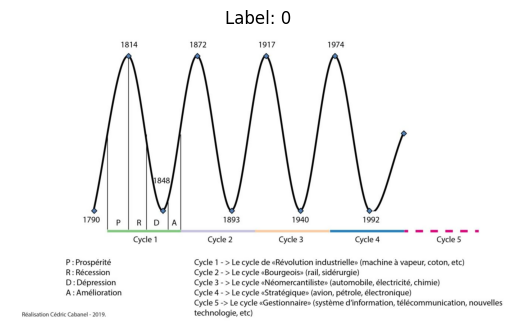

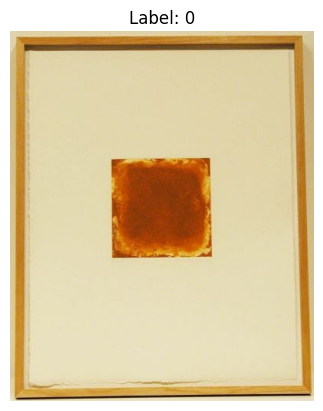

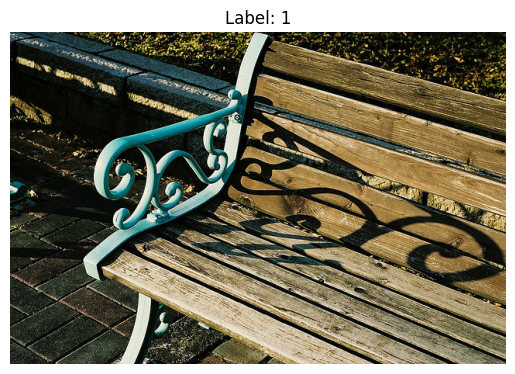

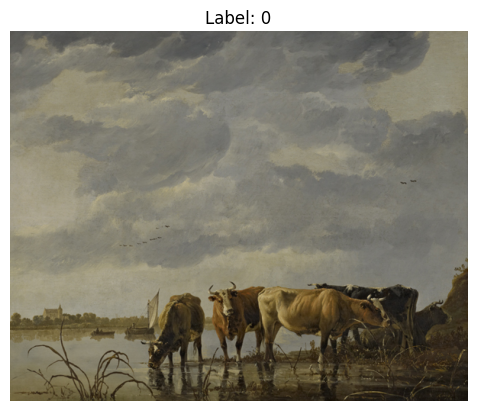

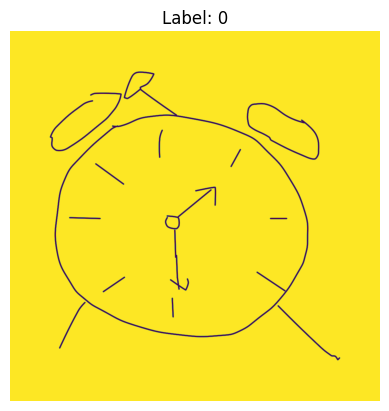

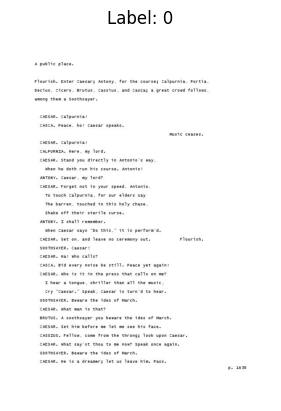

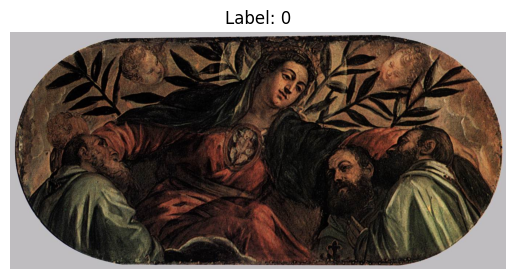

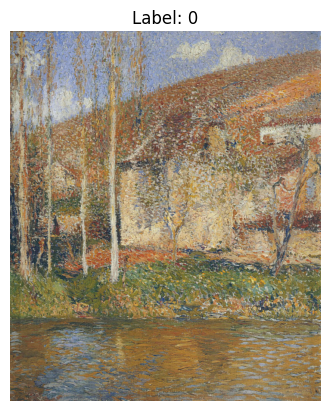

In [4]:
import random
from PIL import Image
for i in range(8):
    sample = df.sample(1).iloc[0]
    img = Image.open(sample['image_path'])
    plt.imshow(img)
    plt.title(f"Label: {sample['label']}")
    plt.axis('off')
    plt.show()


In [9]:
# Équilibrer le dataset en sous-échantillonnant la classe majoritaire
photo_count = df[df['label'] == 1].shape[0]
df_photo = df[df['label'] == 1]
df_other = df[df['label'] == 0].sample(n=photo_count, random_state=42)  # Sous-échantillonnage

# Combiner les classes équilibrées
balanced_df = pd.concat([df_photo, df_other])
print(f"Balanced dataset size: {len(balanced_df)}")
print(balanced_df['label'].value_counts())


# Réduire le dataset à 10 000 images (optionnel)
balanced_df = balanced_df.sample(n=10000, random_state=42)
print(f"Final dataset size: {len(balanced_df)}")
print(balanced_df['label'].value_counts())

Balanced dataset size: 19986
label
1    9993
0    9993
Name: count, dtype: int64
Final dataset size: 10000
label
1    5036
0    4964
Name: count, dtype: int64


Affichez quelques échantillons pour vous assurer que les images et leurs étiquettes sont correctes

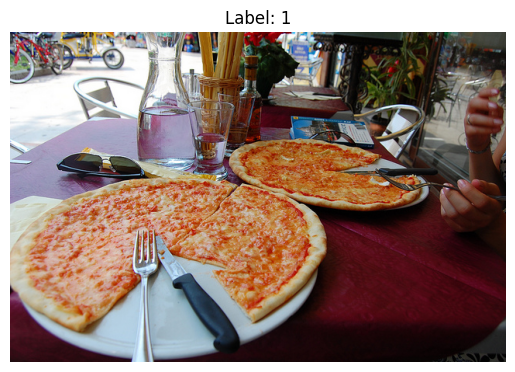

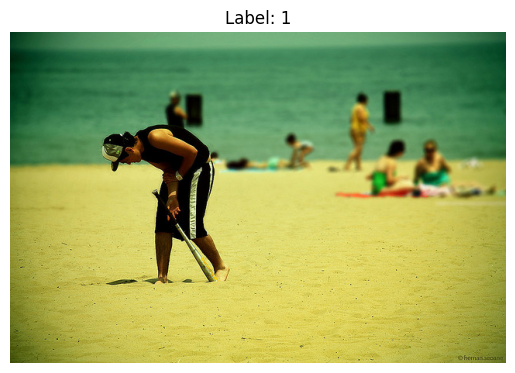

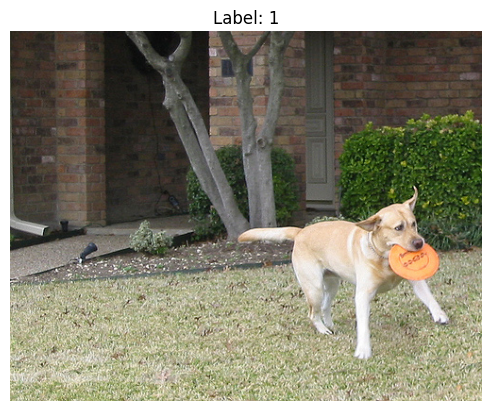

In [10]:
for i in range(3):
    sample = balanced_df.sample(1).iloc[0]
    img = Image.open(sample['image_path'])
    plt.imshow(img)
    plt.title(f"Label: {sample['label']}")
    plt.axis('off')
    plt.show()


In [11]:
# Séparer le dataset en ensembles d'entraînement et de validation
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df['label'])
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 8000
Validation set size: 2000


In [12]:
# Définir la classe personnalisée pour le Dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        try:
            # Ouvrir l'image
            image = Image.open(img_path).convert('RGB')
        except (UnidentifiedImageError, FileNotFoundError) as e:
            print(f"Skipping file {img_path} due to error: {e}")
            return None, None  # Retourner None pour image et label

        if self.transform:
            image = self.transform(image)

        return image, label

# Fonction de collate personnalisée pour gérer les valeurs None
def collate_fn(batch):
    batch = [item for item in batch if item[0] is not None]  # Filtrer les None
    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])  # Retourner des tenseurs vides si le batch est vide
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels

# Définir les transformations avec augmentation pour l'entraînement
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations pour la validation (sans augmentation)
val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Créer les datasets et dataloaders
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)

print("Datasets and Dataloaders created successfully.")

Datasets and Dataloaders created successfully.


In [13]:
# Définir le modèle de classification binaire sans Sigmoid (utilisation de BCEWithLogitsLoss)
class BinaryClassificationModel(nn.Module):
    def __init__(self, base_model):
        super(BinaryClassificationModel, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.5)  # Ajout de Dropout pour la régularisation
        self.fc = nn.Linear(base_model.fc.in_features, 1)
        self.base_model.fc = nn.Identity()  # Supprimer la couche entièrement connectée finale

    def forward(self, x):
        features = self.base_model(x)
        features = self.dropout(features)
        out = self.fc(features)
        return out  # Pas de Sigmoid ici, intégré dans la fonction de perte

# Charger un modèle ResNet50 préentraîné en utilisant le paramètre 'weights'
weights = ResNet50_Weights.DEFAULT
base_model = resnet50(weights=weights)
model = BinaryClassificationModel(base_model)

# Déplacer le modèle vers le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded on device: {device}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


Model loaded on device: cuda


In [15]:
# Définir la fonction de perte
criterion = nn.BCEWithLogitsLoss()

# Définir l'optimiseur avec Weight Decay pour la régularisation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Taux d'apprentissage réduit

# Définir le scheduler pour ajuster le taux d'apprentissage
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

print("Loss function, optimizer, and scheduler defined successfully.")

Loss function, optimizer, and scheduler defined successfully.


In [16]:
for param_group in optimizer.param_groups:
    print(f"Learning Rate: {param_group['lr']}")


Learning Rate: 0.0001


In [20]:
# Initialiser les listes pour stocker les métriques
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

# Paramètres pour Early Stopping
best_val_accuracy = 0.0
patience = 3
trigger_times = 0

# Initialiser le scaler pour l'entraînement en précision mixte
scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

print("Training configuration initialized.")

Training configuration initialized.


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
# Définir le nombre d'epochs
num_epochs = 10

In [24]:
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [26]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        if len(images) == 0:  # Passer les batches vides
            continue
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()

        # Vérification pour `autocast`
        if torch.cuda.is_available():
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
        else:
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            if len(images) == 0:
                continue
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {val_f1:.4f}")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Early Stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved with Val Accuracy: {best_val_accuracy:.4f}")
    else:
        trigger_times += 1
        print(f"No improvement in Val Accuracy. Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print('Early stopping!')
            break


Epoch 1/10 - Validation: 100%|██████████| 63/63 [00:27<00:00,  2.33it/s]


Epoch [1/10], Train Loss: 0.0389, Val Loss: 0.0326, Val Accuracy: 0.9875, Val F1-Score: 0.9875
Best model saved with Val Accuracy: 0.9875


Epoch 2/10 - Validation: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s]


Epoch [2/10], Train Loss: 0.0326, Val Loss: 0.0363, Val Accuracy: 0.9890, Val F1-Score: 0.9891
Best model saved with Val Accuracy: 0.9890


Epoch 3/10 - Validation: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch [3/10], Train Loss: 0.0313, Val Loss: 0.0543, Val Accuracy: 0.9820, Val F1-Score: 0.9822
No improvement in Val Accuracy. Trigger times: 1/3


Epoch 4/10 - Validation: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch [4/10], Train Loss: 0.0137, Val Loss: 0.0267, Val Accuracy: 0.9895, Val F1-Score: 0.9896
Best model saved with Val Accuracy: 0.9895


Epoch 5/10 - Validation: 100%|██████████| 63/63 [00:28<00:00,  2.19it/s]


Epoch [5/10], Train Loss: 0.0130, Val Loss: 0.0670, Val Accuracy: 0.9765, Val F1-Score: 0.9771
No improvement in Val Accuracy. Trigger times: 1/3


Epoch 6/10 - Validation: 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]


Epoch [6/10], Train Loss: 0.0187, Val Loss: 0.0420, Val Accuracy: 0.9860, Val F1-Score: 0.9862
No improvement in Val Accuracy. Trigger times: 2/3


Epoch 7/10 - Validation: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s]

Epoch [7/10], Train Loss: 0.0113, Val Loss: 0.0447, Val Accuracy: 0.9870, Val F1-Score: 0.9871
No improvement in Val Accuracy. Trigger times: 3/3
Early stopping!


<ipython-input-27-154f55ac0bc7>:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


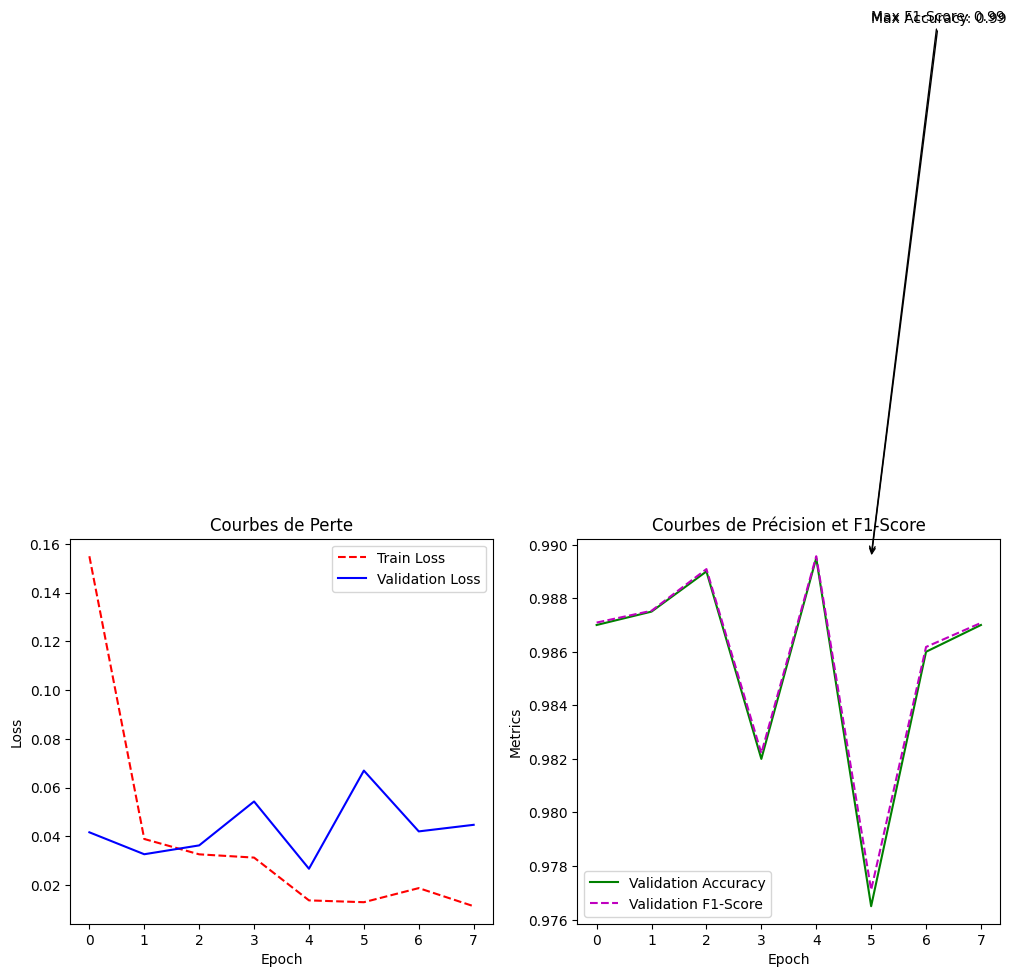

In [27]:
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'r--', label='Train Loss')
plt.plot(val_losses, 'b-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Courbes de Perte')

# Courbes de précision et F1-Score
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'g-', label='Validation Accuracy')
plt.plot(val_f1_scores, 'm--', label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.title('Courbes de Précision et F1-Score')

# Ajouter des annotations
max_acc_epoch = val_accuracies.index(max(val_accuracies)) + 1
max_f1_epoch = val_f1_scores.index(max(val_f1_scores)) + 1
plt.annotate(f"Max Accuracy: {max(val_accuracies):.2f}",
             xy=(max_acc_epoch, max(val_accuracies)),
             xytext=(max_acc_epoch, max(val_accuracies) + 0.02),
             arrowprops=dict(facecolor='green', arrowstyle='->'))
plt.annotate(f"Max F1-Score: {max(val_f1_scores):.2f}",
             xy=(max_f1_epoch, max(val_f1_scores)),
             xytext=(max_f1_epoch, max(val_f1_scores) + 0.02),
             arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.tight_layout()
plt.show()


In [32]:
base_model = resnet50(weights=ResNet50_Weights.DEFAULT)  # Recharger ResNet50 avec ses poids préentraînés
best_model = BinaryClassificationModel(base_model)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model = best_model.to(device)
best_model.eval()

# Évaluation finale sur l'ensemble de validation
val_loss = 0.0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Evaluation"):
        if len(images) == 0:
            continue
        images, labels = images.to(device), labels.float().to(device)
        outputs = best_model(images).squeeze()
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calcul des métriques finales
avg_val_loss = val_loss / len(val_loader)
val_accuracy = accuracy_score(all_labels, all_preds)
val_f1 = f1_score(all_labels, all_preds)

print(f"Final Evaluation - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {val_f1:.4f}")

<ipython-input-32-71f4e124b92a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pth'))
Final Evaluation: 100%|██████████| 

Final Evaluation - Val Loss: 0.0267, Val Accuracy: 0.9895, Val F1-Score: 0.9896


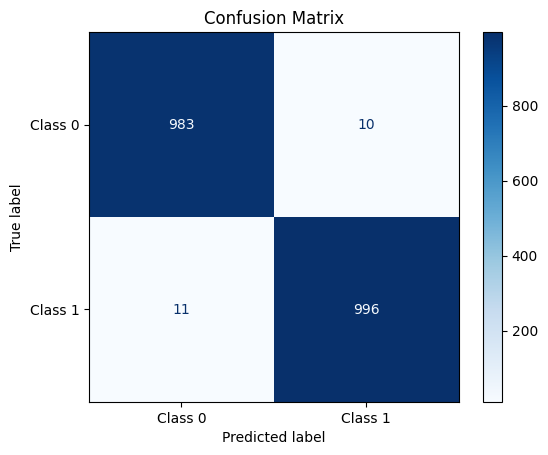

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


<ipython-input-36-0d63c8e43e98>:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  probs = torch.sigmoid(torch.tensor(all_preds)).numpy()


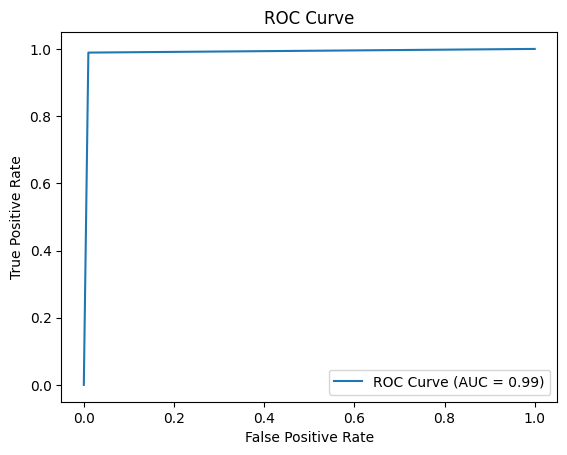

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve

probs = torch.sigmoid(torch.tensor(all_preds)).numpy()
fpr, tpr, _ = roc_curve(all_labels, probs)
auc = roc_auc_score(all_labels, probs)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [30]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
print(report)


              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       993
     Class 1       0.99      0.99      0.99      1007

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

